In [0]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# First we generate the data
def generateDataV1(N):

    x = [1.0]
    y = [1.0]

    corr = 0.25

    for _ in range(N):

        x_innovation = np.random.normal(0., 0.1)
        x_tmp = x[-1] + x_innovation
        y_tmp = y[-1] + corr * x_innovation + np.random.normal(0., 0.1)

        x.append(x_tmp)
        y.append(y_tmp)

    return np.array(x), np.array(y)

def generateDataV2(N):

    x = [1.0]
    y = [1.0]

    corr = 0.25

    corrs = [corr]
    for _ in range(N):

        x_innovation = np.random.normal(0., 0.1)
        x_tmp = x[-1] + x_innovation
        y_tmp = y[-1] + corr * x_innovation + np.random.normal(0., 0.1)

        x.append(x_tmp)
        y.append(y_tmp)

        corr += np.random.normal(0., 0.001)
        corrs.append(corr)

    return np.array(x), np.array(y), np.array(corrs)



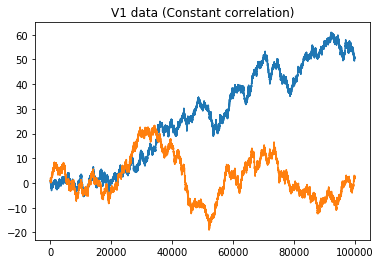

In [3]:
x, y = generateDataV1(100000)

plt.plot(x)
plt.plot(y)
plt.title("V1 data (Constant correlation)")
plt.show()


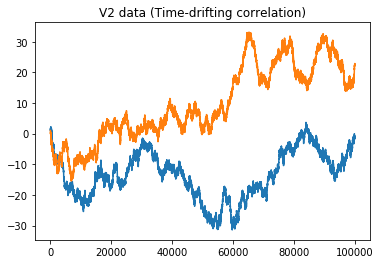

In [4]:
x2, y2, corrs = generateDataV2(100000)

plt.plot(x2)
plt.plot(y2)
plt.title("V2 data (Time-drifting correlation)")
plt.show()



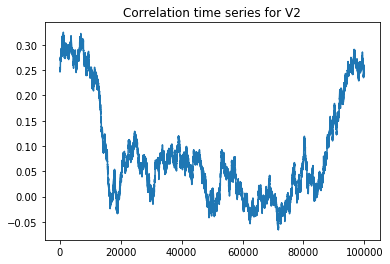

In [5]:
plt.plot(corrs)
plt.title("Correlation time series for V2")
plt.show()



In [6]:
# Now we model the V1 data, and examine the stability of the correlation
import theano.tensor as tt
with pm.Model() as model1:

    def custom_likelihood(x_diffs, y_obs_last, y_obs):

        # Model is: y(t) = y(t-1) + correlation * [x(t) - x(t-1)]
        expected = y_obs_last + corr * x_diffs
        return pm.Normal.dist(mu=expected, sd=0.01).logp(y_obs)

    step_size = pm.Uniform('step_size', lower=0.0, upper=1.)
    corr = pm.GaussianRandomWalk('corr', mu=0, sd=step_size, shape=100)
    corr = tt.repeat(corr, 1000)

    pm.DensityDist('obs', custom_likelihood, observed={
        'x_diffs': (x[:-1] - x[1:]),
        'y_obs_last': y[1:],
        'y_obs': y[:-1]
    })

    mean_field = pm.fit(n=10000, method='advi', obj_optimizer=pm.adam(learning_rate=0.02))
    trace = mean_field.sample(1000)



Average Loss = 4.6184e+06: 100%|██████████| 10000/10000 [00:16<00:00, 592.83it/s]
Finished [100%]: Average Loss = 4.6184e+06


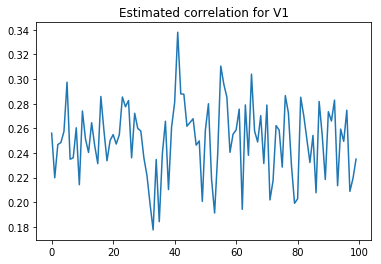

In [7]:
estimated_corrs = np.median(trace['corr'], axis=0)

plt.plot(estimated_corrs)
plt.title("Estimated correlation for V1")
plt.show()



In [8]:
# Now we model the V2 data, and examine the stability of the correlation
with pm.Model() as model2:

    def custom_likelihood(x_diffs, y_obs_last, y_obs):
        expected = y_obs_last + corr * x_diffs
        return pm.Normal.dist(mu=expected, sd=0.01).logp(y_obs)

    step_size = pm.Uniform('step_size', lower=0.0001, upper=1.)
    corr = pm.GaussianRandomWalk('corr', mu=0, sd=step_size, shape=100)
    corr = tt.repeat(corr, 1000)

    pm.DensityDist('obs', custom_likelihood, observed={
        'x_diffs': (x2[:-1] - x2[1:]),
        'y_obs_last': y2[1:],
        'y_obs': y2[:-1]
    })

    mean_field = pm.fit(n=10000, method='advi', obj_optimizer=pm.adam(learning_rate=0.02))
    trace = mean_field.sample(1000)

    # pm.traceplot(trace)
    # plt.show()



Average Loss = 4.6399e+06: 100%|██████████| 10000/10000 [00:18<00:00, 546.25it/s]
Finished [100%]: Average Loss = 4.6399e+06


ImportError: ignored

In [0]:
estimated_corrs = np.repeat(np.median(trace['corr'], axis=0), 1000)
plt.plot(estimated_corrs, color='r', label='Estimated')
plt.plot(corrs, color='b', label='Actual')
plt.legend(loc='upper left')
plt.title("Estimated correlations for V2")
plt.show()



In [0]:
# Estimated parameters for the dynamic correlation (V2)
estimated_step_size = np.median(trace['step_size'])
estimated_last_value = estimated_corrs[-1]

print("Estimated step size = ", estimated_step_size)



In [0]:
# Generate monte carlo simulation for the next 100 time steps
simulations = []
for _ in range(1000):
    sim = [estimated_last_value]
    for _ in range(100):
        sim.append(sim[-1] + np.random.normal(0, estimated_step_size))

    simulations.append(np.repeat(sim, 1000))
    plt.plot(sim)

plt.title("Monte Carlo simulation of correlation for next 1000 points")
plt.show()

simulations = np.array(simulations)

p75 = np.percentile(simulations, 75, axis=0)
median = np.median(simulations, axis=0)
p25 = np.percentile(simulations, 25, axis=0)

estimatedMedian = np.concatenate((estimated_corrs, median))
estimated75 = np.concatenate((estimated_corrs, p75))
estimated25 = np.concatenate((estimated_corrs, p25))

plt.plot(corrs, color='b', label='Actual')
plt.plot(estimatedMedian, color='g', label='Median estimate')
plt.plot(estimated75, color='r', alpha=0.3, label='75th percentile')
plt.plot(estimated25, color='r', alpha=0.3, label='25th percentile')

plt.title("Prediction cone for correlation")
plt.axvline(x=len(corrs), linestyle='--', color='r', alpha=0.5)
plt.show()